In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import pickle
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn import linear_model, tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RepeatedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv('titanic.csv')
# Pclass - ticket class 1 = 1st, 2 = 2nd, 3 = 3rd, proxy for socio-economic status
# SibSp - # sibling/spouses aboard
# parch - # parents/children aboard
# ticket - ticket number
# fare - passenger fare
# cabin - cabin number
# embarked - port of embarkation C = Cherbourg, Q = Queenstown, S = Southampton
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
df.columns = ['id', 'survived', 'ticket_class', 'name', 'sex', 'age', 'num_sibsp', \
              'num_parch', 'ticket_num', 'fare', 'cabin_num', 'emb_port']

#### Data Cleaning

In [4]:
print('num of rows: {} \n'.format(len(df)))
print('attributes: {} \n'.format(df.columns.values))

df.isnull().sum()

num of rows: 891 

attributes: ['id' 'survived' 'ticket_class' 'name' 'sex' 'age' 'num_sibsp' 'num_parch'
 'ticket_num' 'fare' 'cabin_num' 'emb_port'] 



id                0
survived          0
ticket_class      0
name              0
sex               0
age             177
num_sibsp         0
num_parch         0
ticket_num        0
fare              0
cabin_num       687
emb_port          2
dtype: int64

In [5]:
df = df[df['emb_port'].isna()==False]
median_age = df['age'].median()
df['age'] = df['age'].fillna(median_age)

In [30]:
n_survived = len(df[df['survived']==1])
n_not_survived = len(df[df['survived']==0])
print('number survived: {}, number not survived: {}, ratio: {}'.format(n_survived, n_not_survived, n_survived/n_not_survived))

number survived: 340, number not survived: 549, ratio: 0.6193078324225865


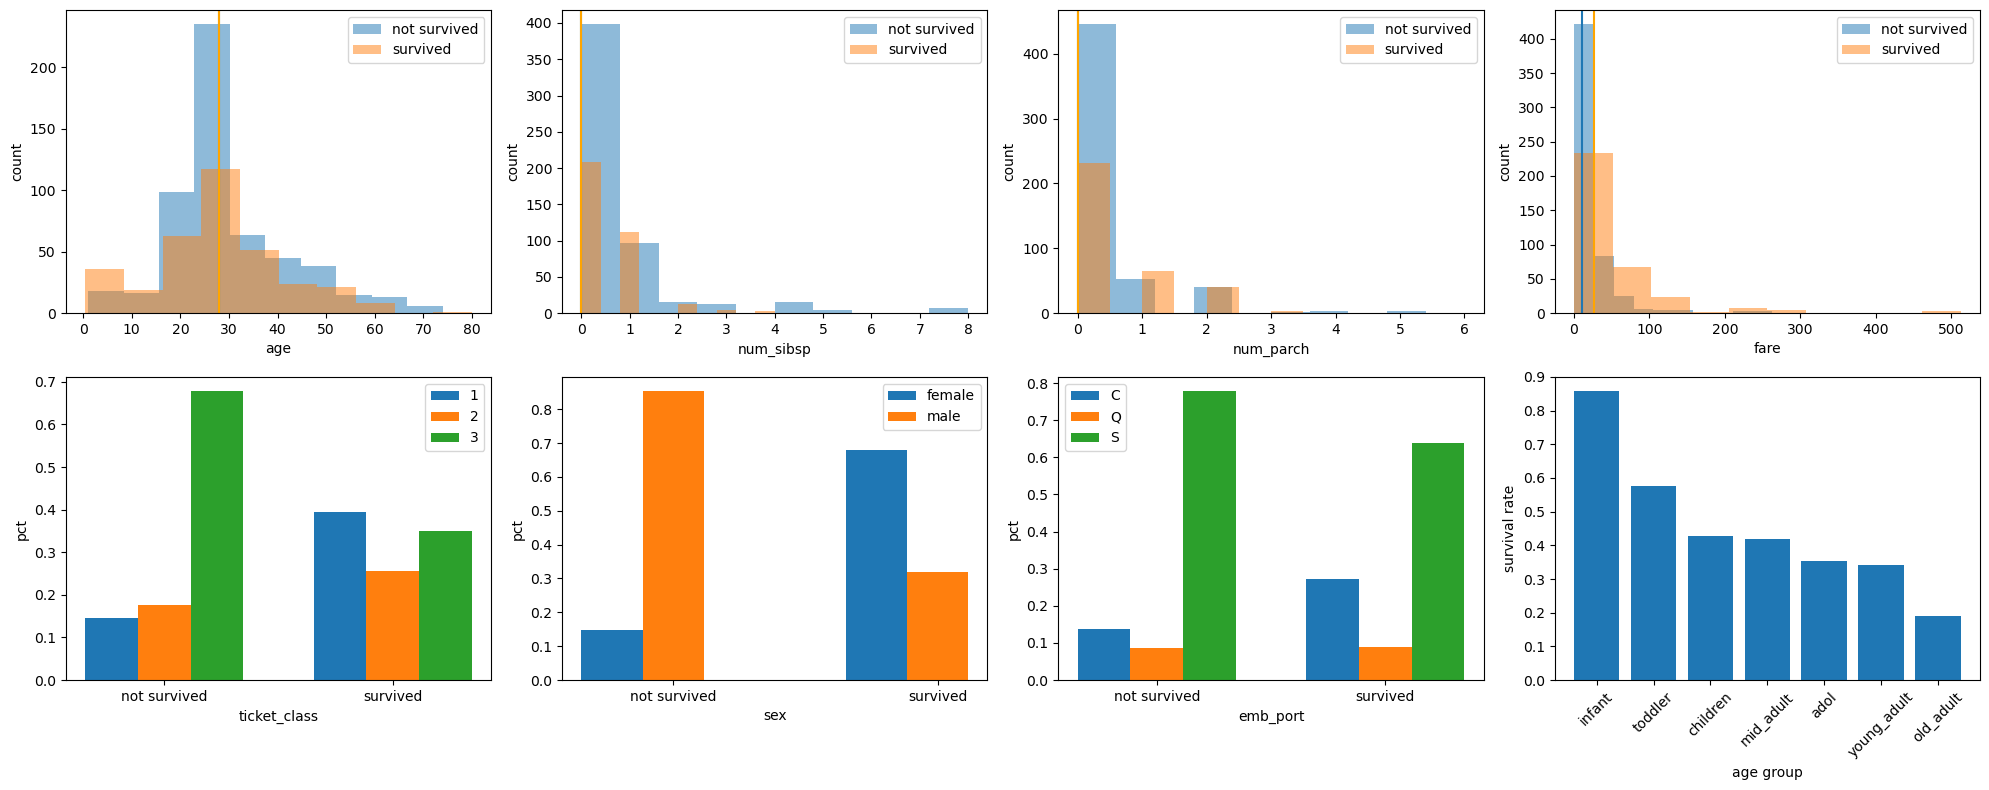

In [7]:
numerical_columns = ['age', 'num_sibsp', 'num_parch', 'fare']
categorical_columns = ['ticket_class', 'sex', 'emb_port']
fig, ax = plt.subplots(2, 4, figsize=(20, 8))
for i, c in enumerate(numerical_columns):
    ax[0][i].hist(df[df['survived']==0][c], alpha=0.5, label='not survived')
    ax[0][i].hist(df[df['survived']==1][c], alpha=0.5, label='survived')
    ax[0][i].axvline(df[df['survived']==0][c].median())
    ax[0][i].axvline(df[df['survived']==1][c].median(), color='orange')
    ax[0][i].set_xlabel(c)
    ax[0][i].set_ylabel('count')
    ax[0][i].legend()

for i, c in enumerate(categorical_columns):
    num_categories = df[c].nunique()
    
    pivot = df.groupby([c, 'survived']).size().unstack(fill_value=0)
    pivot['pct_of_not_survived'] = pivot.iloc[:, 0]/n_not_survived
    pivot['pct_of_survived'] = pivot.iloc[:, 1]/n_survived
    ind = np.array([0, 1.3])
    width = 0.3
    
    for j in range(num_categories):
        values = pivot.iloc[j, 2:4].values
        ax[1][i].bar(ind + width*j, values, width, label=str(pivot.index.values[j]))
        ax[1][i].set_ylabel('pct')
    ax[1][i].set_xticks(ind + width, ('not survived', 'survived'))
    ax[1][i].set_xlabel(c)
    ax[1][i].legend(loc='best')

def get_age_group(age):
    if age <= 1:
        return 'infant'
    elif age <= 4:
        return 'toddler'
    elif age <= 11:
        return 'children'
    elif age <= 21:
        return 'adol'
    elif age <= 30:
        return 'young_adult'
    elif age <= 60:
        return 'mid_adult'
    else:
        return 'old_adult'

def get_age_group_encoding(age):
    if age <= 1:
        return 0
    elif age <= 4:
        return 1
    elif age <= 11:
        return 2
    elif age <= 21:
        return 3
    elif age <= 30:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6

        
df['age_group'] = df['age'].apply(get_age_group)
df['age_group_encoding'] = df['age'].apply(get_age_group_encoding)
survived_age_group = df.groupby('age_group')['survived'].sum()/df.groupby('age_group')['survived'].count()
survived_age_group = survived_age_group.sort_values()[::-1]
ax[1, 3].bar(survived_age_group.index, survived_age_group.values)
# plt.bar(survived_age_group.index, 1-survived_age_group.values, bottom=survived_age_group.values)
ax[1, 3].set_xlabel('age group')
ax[1, 3].set_ylabel('survival rate')
ax[1, 3].tick_params(axis='x', rotation=45)
             
fig.tight_layout()

### Hypothesis Test

In [8]:
from scipy import stats

In [9]:
for c in numerical_columns:
    survived_group = df[(df['survived']==1) & (df[c].isna()==False)][c].values
    not_survived_group = df[(df['survived']==0) & (df[c].isna()==False)][c].values
    t_stat, p_value = stats.ttest_ind(survived_group, not_survived_group)
    print('mean {} for survived: {}, mean {} for not survived {}'\
          .format(c, np.round(np.mean(survived_group), 2), c, np.round(np.mean(not_survived_group)), 2))
    print('t stat:{}, p value:{}'.format(t_stat, p_value))
    print('===============================================================================================================')

mean age for survived: 28.16, mean age for not survived 30.0
t stat:-2.0845555524766253, p value:0.03739522542606732
mean num_sibsp for survived: 0.48, mean num_sibsp for not survived 1.0
t stat:-1.0143856691716167, p value:0.3106753734113619
mean num_parch for survived: 0.47, mean num_parch for not survived 0.0
t stat:2.485047751635148, p value:0.013136766201094989
mean fare for survived: 48.21, mean fare for not survived 22.0
t stat:7.8637704094143785, p value:1.0797887540538483e-14


In [10]:
for c in categorical_columns:   
    crosstab = pd.crosstab(df["survived"], df[c])
    chi_stat, p_value, _, _ = stats.chi2_contingency(crosstab)
    for category in crosstab.columns:
        print('pct {} {} of not survived: {}, pct {} {} of survived: {}'.format(c, category, np.round((crosstab[category]/crosstab.sum(axis=1))[0], 2), \
                                                                                c, category, np.round((crosstab[category]/crosstab.sum(axis=1))[1], 2)))
    print('chisq stat: {}, p value: {}'.format(chi_stat, p_value))
    print('===============================================================================================================')

pct ticket_class 1 of not survived: 0.15, pct ticket_class 1 of survived: 0.39
pct ticket_class 2 of not survived: 0.18, pct ticket_class 2 of survived: 0.26
pct ticket_class 3 of not survived: 0.68, pct ticket_class 3 of survived: 0.35
chisq stat: 100.98040726128336, p value: 1.1813624785477922e-22
pct sex female of not survived: 0.15, pct sex female of survived: 0.68
pct sex male of not survived: 0.85, pct sex male of survived: 0.32
chisq stat: 258.4266104463763, p value: 3.7799096665576e-58
pct emb_port C of not survived: 0.14, pct emb_port C of survived: 0.27
pct emb_port Q of not survived: 0.09, pct emb_port Q of survived: 0.09
pct emb_port S of not survived: 0.78, pct emb_port S of survived: 0.64
chisq stat: 26.48914983923762, p value: 1.769922284120912e-06


#### Feature Engineering

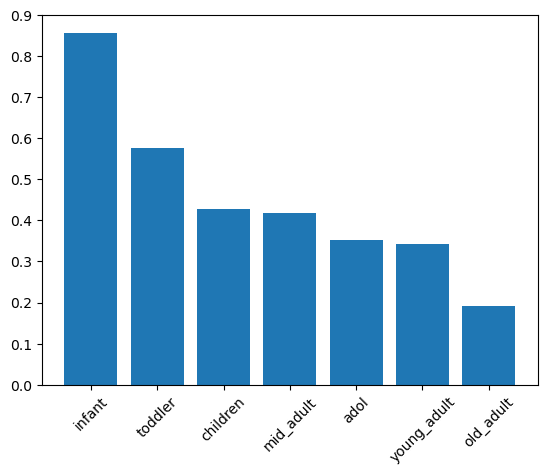

In [11]:
def get_age_group(age):
    if age <= 1:
        return 'infant'
    elif age <= 4:
        return 'toddler'
    elif age <= 11:
        return 'children'
    elif age <= 21:
        return 'adol'
    elif age <= 30:
        return 'young_adult'
    elif age <= 60:
        return 'mid_adult'
    else:
        return 'old_adult'

def get_age_group_encoding(age):
    if age <= 1:
        return 0
    elif age <= 4:
        return 1
    elif age <= 11:
        return 2
    elif age <= 21:
        return 3
    elif age <= 30:
        return 4
    elif age <= 60:
        return 5
    else:
        return 6
        
df['age_group'] = df['age'].apply(get_age_group)
df['age_group_encoding'] = df['age'].apply(get_age_group_encoding)
survived_age_group = df.groupby('age_group')['survived'].sum()/df.groupby('age_group')['survived'].count()
survived_age_group = survived_age_group.sort_values()[::-1]
plt.bar(survived_age_group.index, survived_age_group.values)
plt.xticks(rotation=45)
plt.show()

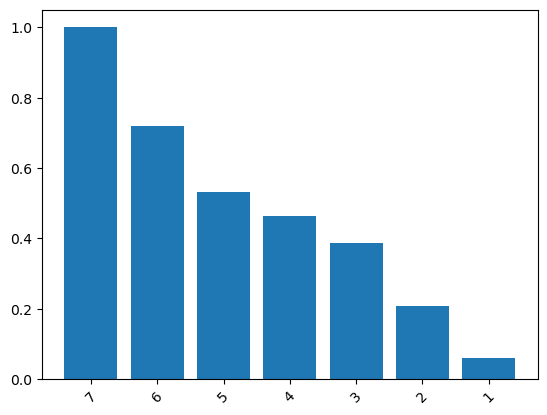

In [12]:
df['fare'].describe()
def get_fare_group(fare):
    if fare <= 5:
        return '1'
    elif fare <= 10: 
        return '2'
    elif fare <= 15:
        return '3'
    elif fare <= 30:
        return '4'
    elif fare <= 100:
        return '5'
    elif fare <= 300:
        return '6'
    else:
        return '7'
df['fare_group'] = df['fare'].apply(get_fare_group)
survived_fare_group = df.groupby('fare_group')['survived'].sum()/df.groupby('fare_group')['survived'].count()
survived_fare_group = survived_fare_group.sort_values()[::-1]
plt.bar(survived_fare_group.index, survived_fare_group.values)
plt.xticks(rotation=45)
plt.show()

In [41]:
df.groupby('emb_port')['fare'].mean()

emb_port
C    59.954144
Q    13.276030
S    27.079812
Name: fare, dtype: float64

In [43]:
df.groupby('emb_port')['ticket_class'].mean()

emb_port
C    1.886905
Q    2.909091
S    2.350932
Name: ticket_class, dtype: float64

#### Correlation

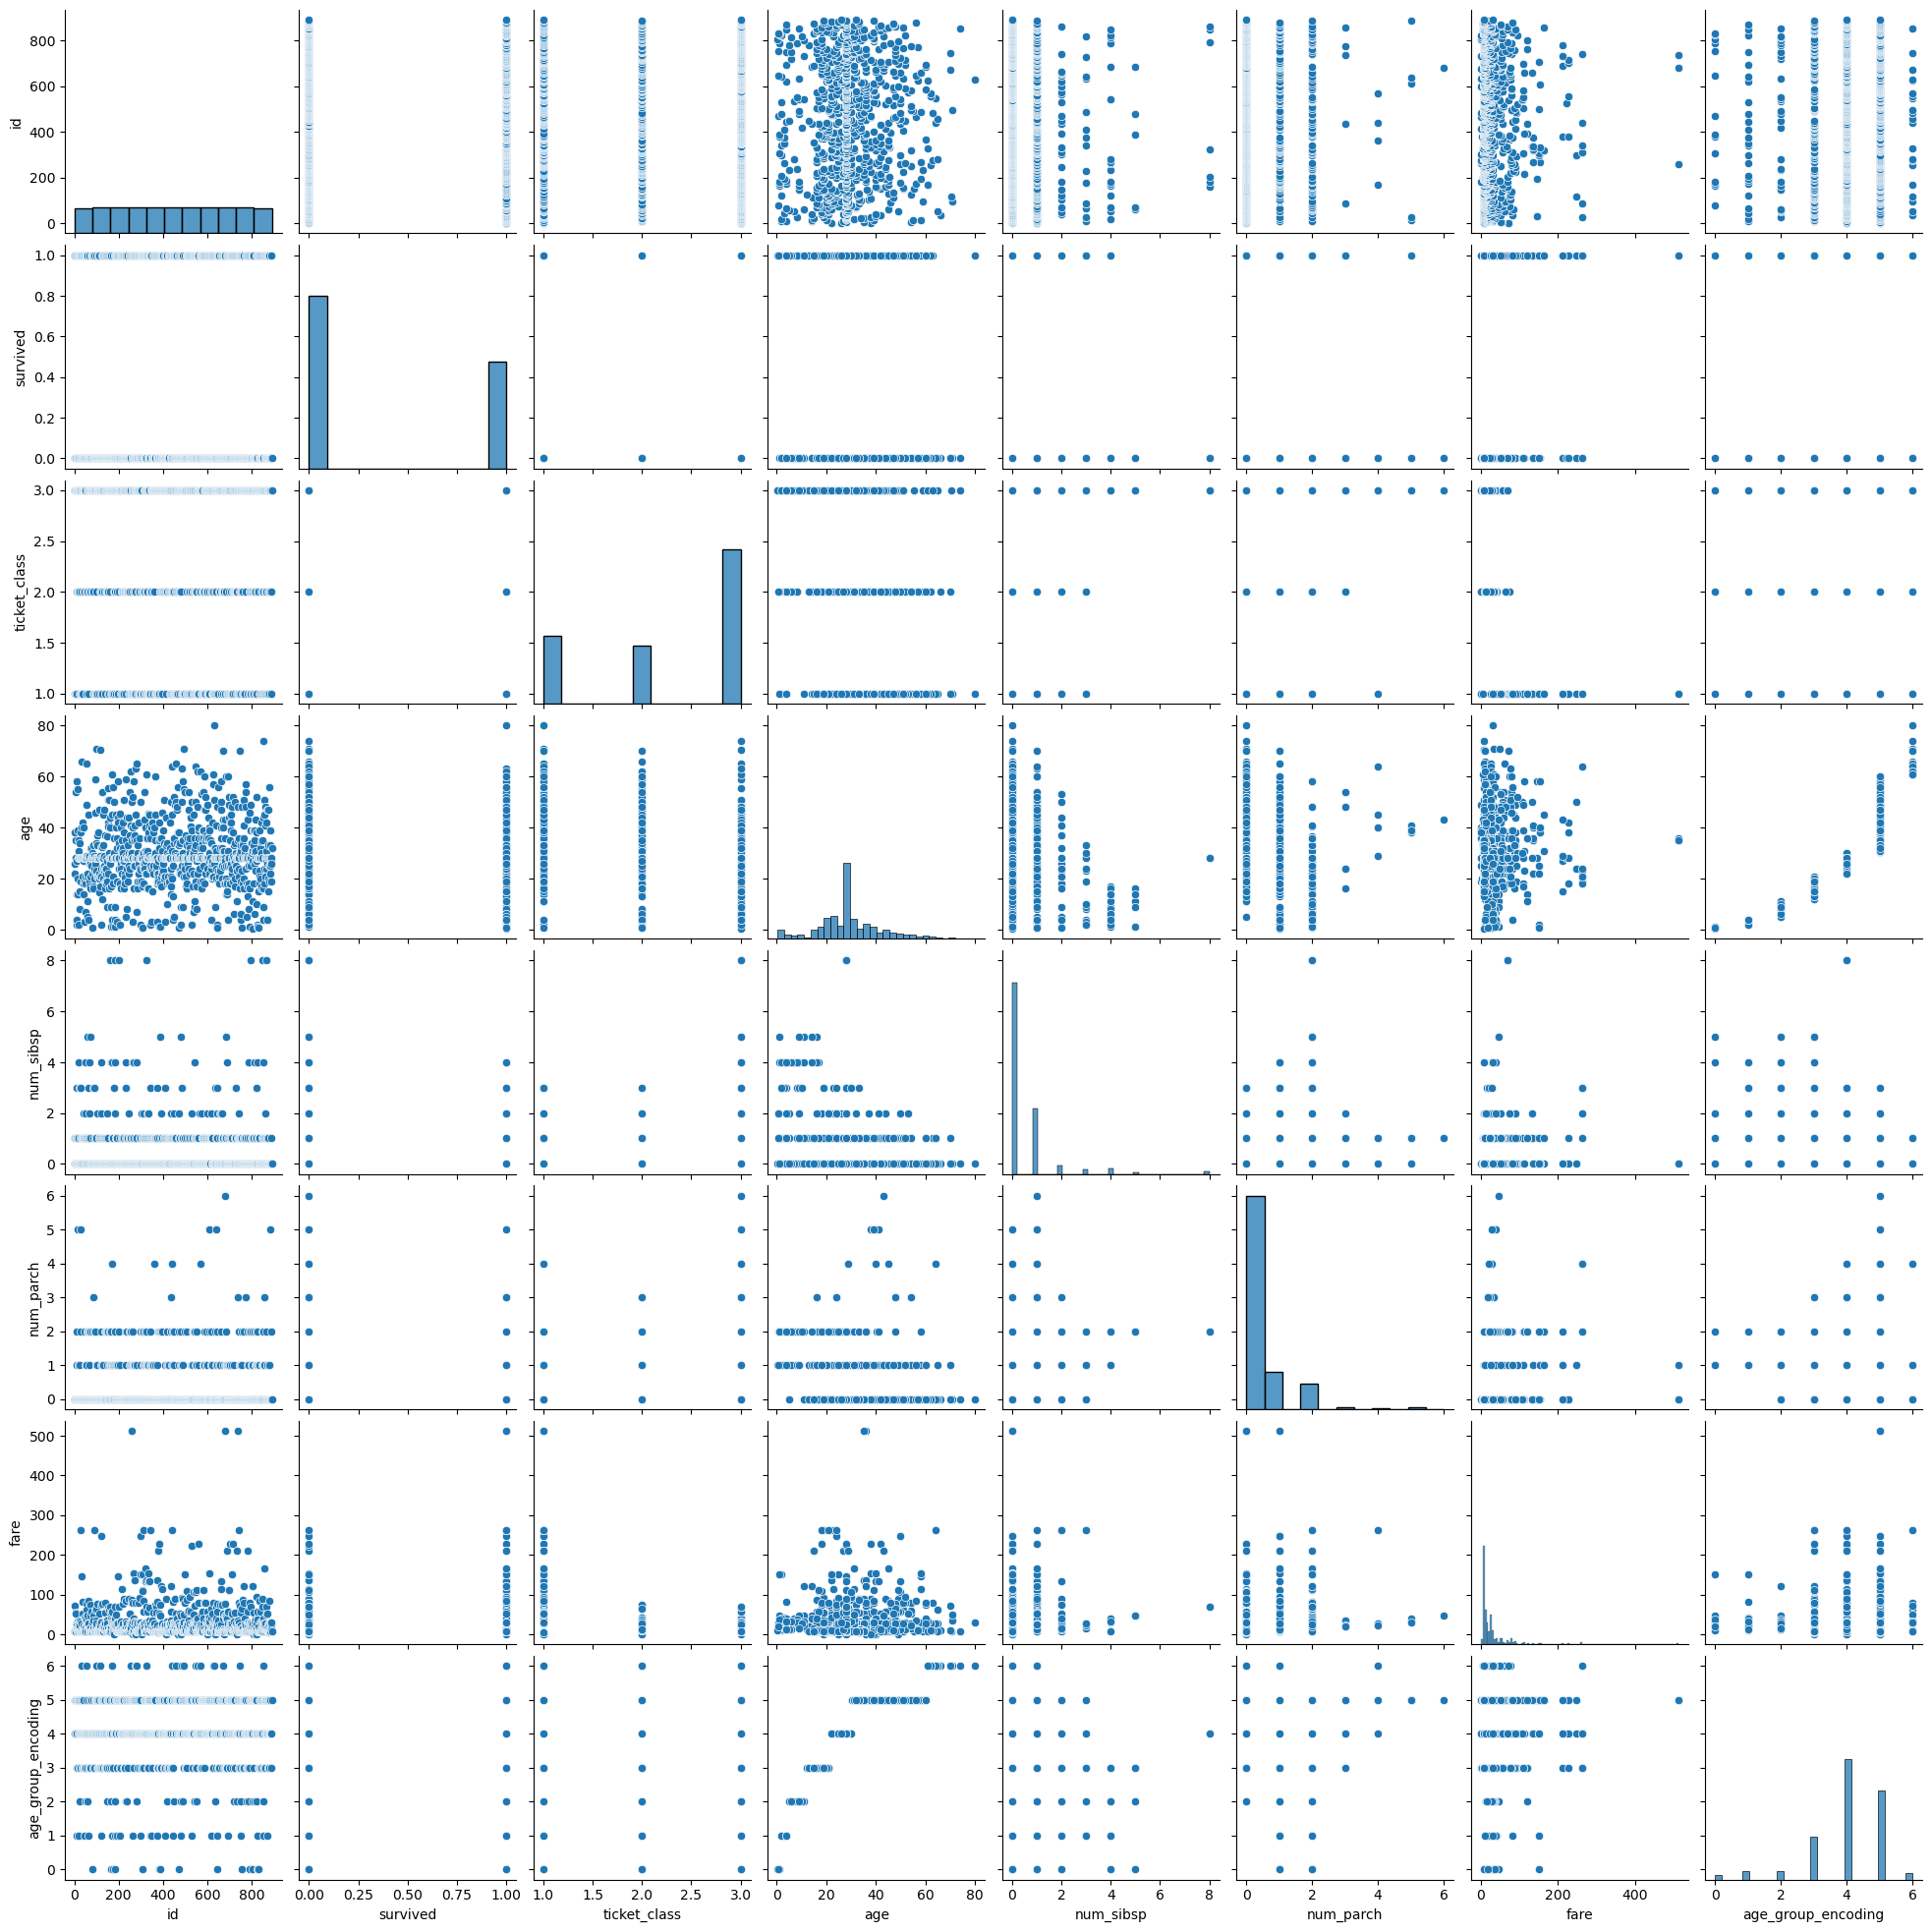

In [13]:
sns.pairplot(df)

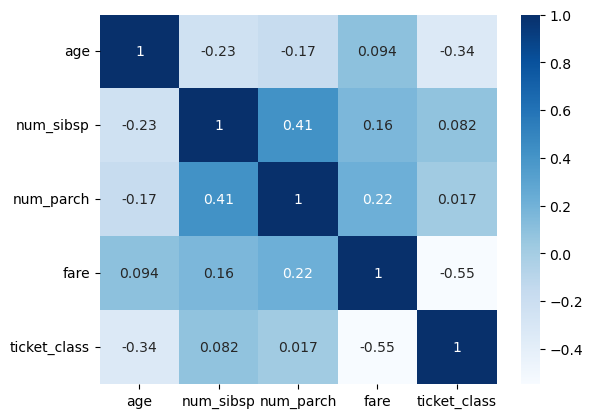

In [14]:
numerical_columns.append('ticket_class')
sns.heatmap(df[numerical_columns].corr(), cmap='Blues', annot=True)
plt.show()

In [15]:
vif_data = pd.DataFrame()
df_numerical = df[numerical_columns]
vif_data["feature"] = df_numerical.columns 
vif_data["VIF"] = [variance_inflation_factor(df_numerical.values, i) 
                          for i in range(len(df_numerical.columns))] 
print(vif_data)

        feature       VIF
0           age  3.882756
1     num_sibsp  1.559519
2     num_parch  1.545806
3          fare  1.661220
4  ticket_class  3.650541


#### Modeling

In [16]:
columns_selected = ['survived', 'ticket_class', 'sex', 'age_group_encoding', 'num_parch', 'fare', 'emb_port']
df_model = df[columns_selected]
df_model.loc[df_model['sex']=='male', 'sex']=0
df_model.loc[df_model['sex']=='female', 'sex']=1
df_model.loc[df_model['emb_port']=='C', 'emb_port']=0
df_model.loc[df_model['emb_port']=='Q', 'emb_port']=1
df_model.loc[df_model['emb_port']=='S', 'emb_port']=2
# df_model.loc[:, 'fare_group'] = df_model['fare_group'].astype('int')

x_train, x_test, y_train, y_test = train_test_split(df_model.loc[:, df_model.columns != 'survived'], df_model['survived'], test_size=0.2, random_state=42)

In [17]:
lr = linear_model.LogisticRegression()
lr.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(lr.predict(x_train), y_train), accuracy_score(lr.predict(x_test), y_test)))

train accuracy: 0.8059071729957806, test accuracy: 0.7808988764044944


In [18]:
ridge = linear_model.RidgeCV(np.logspace(-6, 6, 13))
ridge.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score((ridge.predict(x_train) >= 0.5).astype('int'), y_train), \
                                                     accuracy_score((ridge.predict(x_test) >= 0.5).astype('int'), y_test)))

train accuracy: 0.7876230661040787, test accuracy: 0.7921348314606742


In [19]:
dtree = DecisionTreeClassifier()
dtree.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(dtree.predict(x_train), y_train), accuracy_score(dtree.predict(x_test), y_test)))

train accuracy: 0.9465541490857946, test accuracy: 0.7808988764044944


In [20]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(rf.predict(x_train), y_train), accuracy_score(rf.predict(x_test), y_test)))

train accuracy: 0.9465541490857946, test accuracy: 0.7921348314606742


In [25]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
mfeatures = [2, 3, 4, 5, 6]
grid = dict(learning_rate=learning_rate)
kfold = RepeatedKFold(n_splits=10, random_state=42)
gbc = GradientBoostingClassifier(n_estimators=200,
                                 # learning_rate=0.05,
                                 random_state=42)

grid_search = GridSearchCV(gbc, grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
gbc_best = grid_search.fit(x_train, y_train)

# gbc.fit(x_train, y_train)
print('train accuracy: {}, test accuracy: {}'.format(accuracy_score(gbc_best.predict(x_train), y_train), accuracy_score(gbc_best.predict(x_test), y_test)))

train accuracy: 0.9240506329113924, test accuracy: 0.8314606741573034


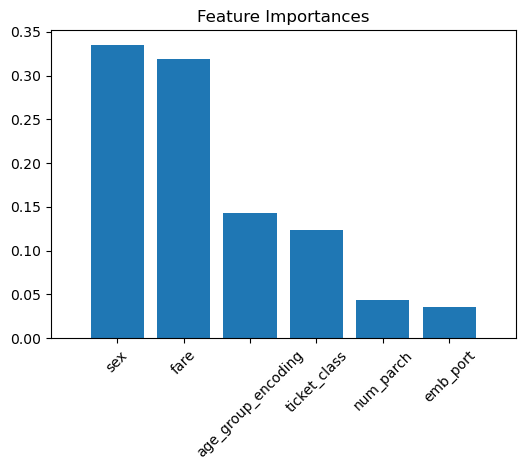

In [32]:
importances = gbc_best.best_estimator_.feature_importances_
importances = dtree.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.title("Feature Importances")
plt.bar(range(x_train.shape[1]), importances[indices], align="center")
plt.xticks(range(x_train.shape[1]), x_train.columns[indices], rotation=45)
plt.xlim([-1, x_train.shape[1]])
plt.show()

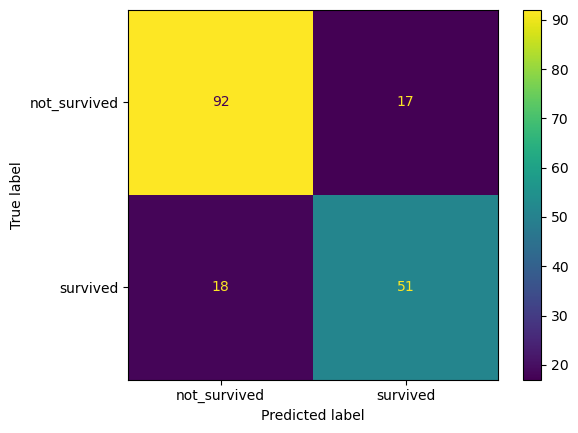

In [23]:
cm = confusion_matrix(y_true=y_test, y_pred=gbc_best.predict(x_test))
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['not_survived', 'survived']) 
cm_display.plot()
# sns.heatmap(cm, annot=True, cmap='Blues')

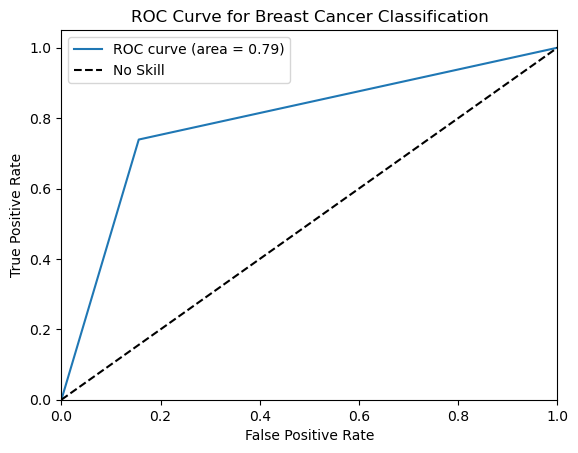

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, gbc_best.predict(x_test))
roc_auc = auc(fpr, tpr)
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Breast Cancer Classification')
plt.legend()
plt.show()

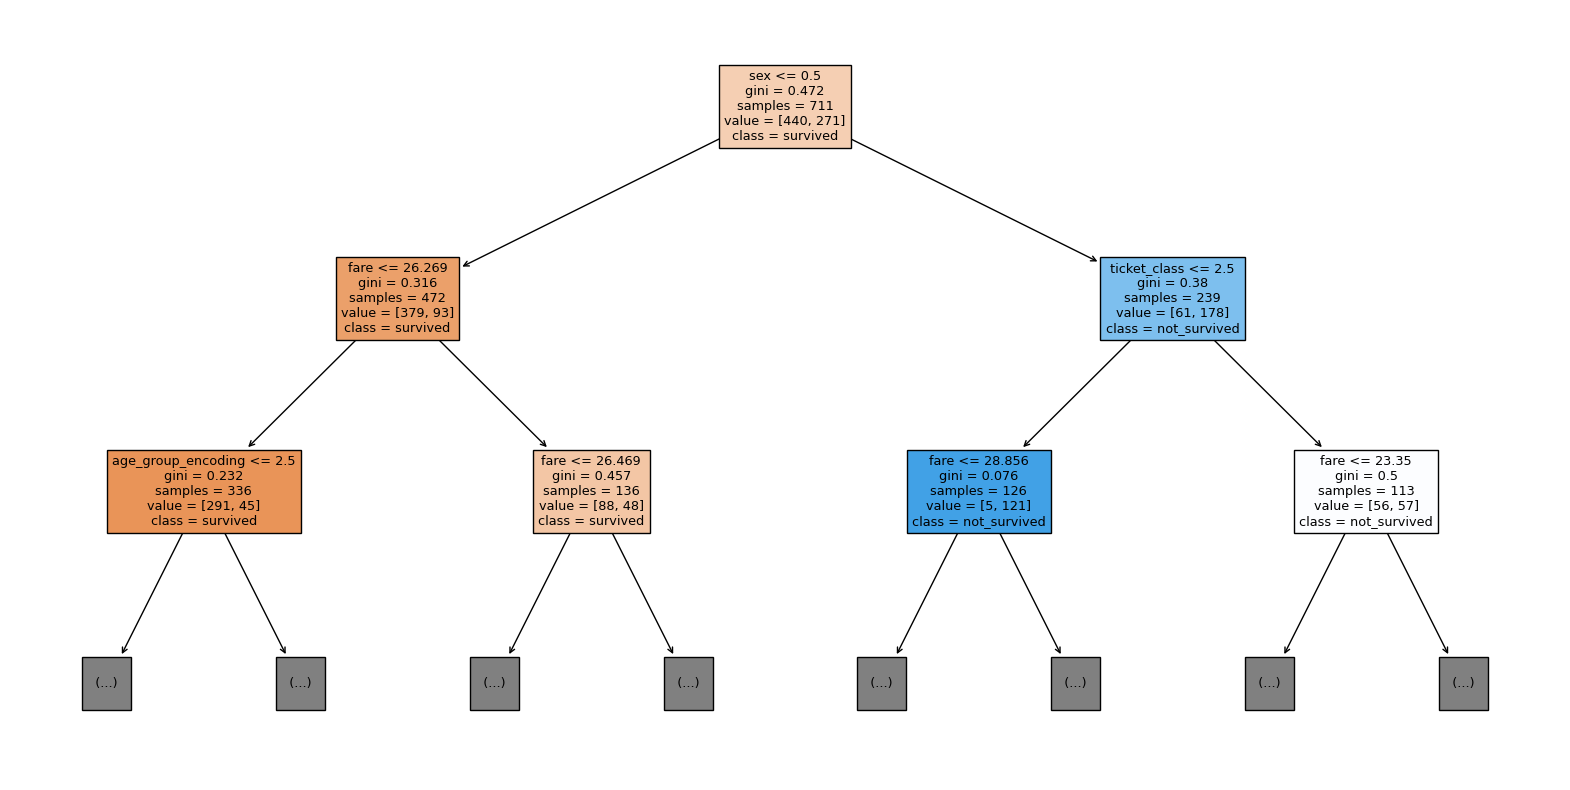

In [38]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=['ticket_class', 'sex', 'age_group_encoding', 'num_parch', 'fare', 'emb_port'], \
          class_names=['survived', 'not_survived'], filled=True, max_depth=2)
plt.show()